In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 118.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense
from tqdm import trange
import math
import cmath
import time
from scipy import constants

#drawModel1D

In [ ]:
#start = time.clock();
# Please check the Magnetic Permeability (H/m)
# at: https://docs.scipy.org/doc/scipy-0.14.0/reference/constants.html#module-scipy.constants
mu = constants.mu_0; #Magnetic Permeability (H/m)
def drawModel1D(ax, thickness=None, values=None, model=None, depths=None,
                plot='plot',
                xlabel=r'Resistividad $(\Omega$m$)$', zlabel='Profundidad (m)',
                z0=0,
                **kwargs):
    """Draw 1d block model into axis ax.

    Draw 1d block model into axis ax defined by values and thickness vectors
    using plot function.
    For log y cases, z0 should be set > 0 so that the default becomes 1.

    Parameters
    ----------
    ax : mpl axes
        Matplotlib Axes object to plot into.

    values : iterable [float]
        [N] Values for each layer plus lower background.

    thickness : iterable [float]
        [N-1] thickness for each layer. Either thickness or depths must be set.

    depths : iterable [float]
        [N-1] Values for layer depths (positive z-coordinates).
        Either thickness or depths must be set.

    model : iterable [float]
        Shortcut to use default model definition.
        thks = model[0:nLay]
        values = model[nLay:]

    plot : string
        Matplotlib plotting function.
        'plot', 'semilogx', 'semilogy', 'loglog'

    xlabel : str
        Label for x axis.

    ylabel : str
        Label for y axis.

    z0 : float
        Starting depth in m

    **kwargs : dict()
        Forwarded to the plot routine

    Examples
    --------
    >>> import matplotlib.pyplot as plt
    >>> import numpy as np
    >>> import pygimli as pg
    >>> # plt.style.use('ggplot')
    >>> thk = [1, 4, 4]
    >>> res = np.array([10., 5, 15, 50])
    >>> fig, ax = plt.subplots()
    >>> pg.viewer.mpl.drawModel1D(ax, values=res*5, depths=np.cumsum(thk),
    ...                          plot='semilogx', color='blue')
    >>> pg.viewer.mpl.drawModel1D(ax, values=res, thickness=thk, z0=1,
    ...                          plot='semilogx', color='red')
    >>> pg.wait()
    """
    if model is not None:
        nLayers = (len(model)-1)//2
        thickness = model[:nLayers]
        values = model[nLayers:]

    if thickness is None and depths is None:
        raise Exception("Either thickness or depths must be given.")

    nLayers = len(values)
    px = np.zeros(nLayers * 2)
    pz = np.zeros(nLayers * 2)

    if thickness is not None:
        z1 = np.cumsum(thickness) + z0
    else:
        z1 = depths

    for i in range(nLayers):
        px[2 * i] = values[i]
        px[2 * i + 1] = values[i]

        if i == nLayers - 1:
            pz[2 * i + 1] = z1[i - 1] * 1.2
        else:
            pz[2 * i + 1] = z1[i]
            pz[2 * i + 2] = z1[i]

    if plot == 'loglog' or plot == 'semilogy':
        if z0 == 0:
            pz[0] = z1[0] / 2.
        else:
            pz[0] = z0

    try:
        plot = getattr(ax, plot)
        plot(px, pz+z0, **kwargs)
    except BaseException as e:
        print(e)

    ax.set_ylabel(zlabel)
    ax.set_xlabel(xlabel)
    # assume positive depths pointing upward
    ax.set_ylim(pz[-1], pz[0])
    ax.grid(True)

#Forward VES

In [ ]:
@tf.function
def forward(res):
    res = tf.cast(res, tf.float64)
    ab2 = tf.cast(np.logspace(0.4, 2.2, 30), dtype=tf.float64)
    lays = tf.shape(res)[0] - 1
    thk = tf.constant(np.logspace(0.0, 0.9, 15), dtype = tf.float64)
    thick = tf.cast(thk, dtype=tf.float64)

    LOG = tf.math.log(tf.cast(10.0, dtype=tf.float64))
    COUNTER = 1 + (2 * 13 - 2)
    UP = tf.exp(0.5 * LOG / 4.438)

    up = ab2 * tf.exp(-10.0 * LOG / 4.438)
    ti = tf.TensorArray(dtype=tf.float64, size=COUNTER)

    for ii in range(COUNTER):
        ti1 = tf.fill(tf.shape(up), res[lays])

        lay = lays
        while lay > 0:
            lay -= 1
            tan_h = tf.tanh(thick[lay] / up)
            ti1 = (ti1 + res[lay] * tan_h) / (1 + ti1 * tan_h / res[lay])

        ti = ti.write(ii, ti1)
        up *= UP

    ti = ti.stack()

    weights = tf.constant([105, 0, -262, 0, 416, 0, -746, 0, 1605, 0, -4390, 0, 13396, 0, -27841,
                           0, 16448, 0, 8183, 0, 2525, 0, 336, 0, 225], dtype=tf.float64)
    weighted_ti = tf.tensordot(weights, ti, axes=1)
    res_a = weighted_ti / 1e4

    return res_a

@tf.function
def forward2(res):
    res = tf.cast(res, tf.float64)
    ab2 = tf.cast(np.logspace(0.4, 2.2, 30), dtype=tf.float64)
    lays = tf.shape(res)[0] - 1
    thk = tf.constant([4, 8, 15, 23], dtype = tf.float64)
    thick = tf.cast(thk, dtype=tf.float64)

    LOG = tf.math.log(tf.cast(10.0, dtype=tf.float64))
    COUNTER = 1 + (2 * 13 - 2)
    UP = tf.exp(0.5 * LOG / 4.438)

    up = ab2 * tf.exp(-10.0 * LOG / 4.438)
    ti = tf.TensorArray(dtype=tf.float64, size=COUNTER)

    for ii in range(COUNTER):
        ti1 = tf.fill(tf.shape(up), res[lays])

        lay = lays
        while lay > 0:
            lay -= 1
            tan_h = tf.tanh(thick[lay] / up)
            ti1 = (ti1 + res[lay] * tan_h) / (1 + ti1 * tan_h / res[lay])

        ti = ti.write(ii, ti1)
        up *= UP

    ti = ti.stack()

    weights = tf.constant([105, 0, -262, 0, 416, 0, -746, 0, 1605, 0, -4390, 0, 13396, 0, -27841,
                           0, 16448, 0, 8183, 0, 2525, 0, 336, 0, 225], dtype=tf.float64)
    weighted_ti = tf.tensordot(weights, ti, axes=1)
    res_a = weighted_ti / 1e4

    return res_a

#Forward MT

In [ ]:
@tf.function
def MTforwardModelTF(resistivities):
    frequencies =tf.cast(np.logspace(-1, 3, 31),dtype=tf.complex128)
    thicknesses =tf.cast(layer_thicknesses_inv,dtype=tf.complex128)
    n = len(resistivities)
    resistivities = tf.cast(resistivities,dtype=tf.complex128)
    #apparentResistivity = tf.TensorArray(dtype=tf.float64, size=0, dynamic_size=True)
    phase = tf.TensorArray(dtype=tf.complex128, size=0, dynamic_size=True)

    for frequency in frequencies:
        w = 2 * math.pi * frequency
        impedances = tf.TensorArray(dtype=tf.complex128, size=n)

        # Compute basement impedance
        impedances = impedances.write(n-1, tf.sqrt(w  *mu*1j * resistivities[n-1]))

        for j in range(n-2, -1, -1):
            resistivity = resistivities[j]
            thickness = thicknesses[j]

            # Compute intrinsic impedance of current layer
            dj = tf.sqrt((w * mu*(1.0/resistivity)) * 1j)
            wj = dj * resistivity

            # Calculate Exponential factor from intrinsic impedance
            ej = tf.exp(-2 * thickness * dj)

            # Calculate reflection coefficient using current layer intrinsic impedance
            # and the below layer impedance
            belowImpedance = impedances.read(j + 1)
            rj = (wj - belowImpedance) / (wj + belowImpedance)
            re = rj * ej
            Zj = wj * ((1 - re) / (1 + re))
            impedances = impedances.write(j, Zj)

        # Compute apparent resistivity from top layer impedance
        Z = impedances.read(0)
        absZ = tf.abs(Z)
        phase = phase.write(phase.size(), Z)

    return phase.stack()

@tf.function
def MTforwardModelTF2(layer_thicknesses_inv,resistivities):
    frequencies =tf.cast(np.logspace(-1, 3, 31),dtype=tf.complex128)
    thicknesses =tf.cast(layer_thicknesses_inv,dtype=tf.complex128)

    resistivities = tf.cast(resistivities,dtype=tf.complex128)
    n = resistivities.shape[0]
    #apparentResistivity = tf.TensorArray(dtype=tf.float64, size=0, dynamic_size=True)
    phase = tf.TensorArray(dtype=tf.complex128, size=0, dynamic_size=True)

    for frequency in frequencies:
        w = 2 * math.pi * frequency
        impedances = tf.TensorArray(dtype=tf.complex128, size=n)

        # Compute basement impedance
        impedances = impedances.write(n-1, tf.sqrt(w  *mu*1j * resistivities[n-1]))

        for j in range(n-2, -1, -1):
            resistivity = resistivities[j]
            thickness = thicknesses[j]

            # Compute intrinsic impedance of current layer
            dj = tf.sqrt((w * mu*(1.0/resistivity)) * 1j)
            wj = dj * resistivity

            # Calculate Exponential factor from intrinsic impedance
            ej = tf.exp(-2 * thickness * dj)

            # Calculate reflection coefficient using current layer intrinsic impedance
            # and the below layer impedance
            belowImpedance = impedances.read(j + 1)
            rj = (wj - belowImpedance) / (wj + belowImpedance)
            re = rj * ej
            Zj = wj * ((1 - re) / (1 + re))
            impedances = impedances.write(j, Zj)

        # Compute apparent resistivity from top layer impedance
        Z = impedances.read(0)
        absZ = tf.abs(Z)
        phase = phase.write(phase.size(), Z)

    return phase.stack()

#VES synthetic model

In [ ]:
synRES = tf.constant([15, 150, 250, 90, 50], dtype = tf.float64)
synTHK = tf.constant([4, 8, 15, 23], dtype = tf.float64)

tf.Tensor([ 4.  8. 15. 23.], shape=(4,), dtype=float64)


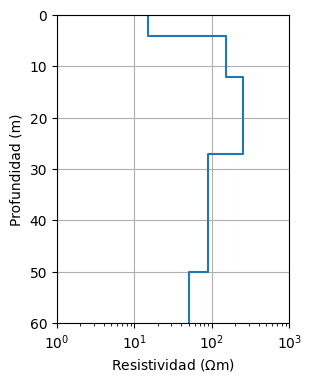

In [ ]:
fig, ax = plt.subplots(figsize=(3,4))
drawModel1D(ax, synTHK, synRES,plot='semilogx')
plt.xlim([1,10**3])
print(synTHK)

#MT synthetic model

[4, 8, 15, 23, 50, 100, 150]


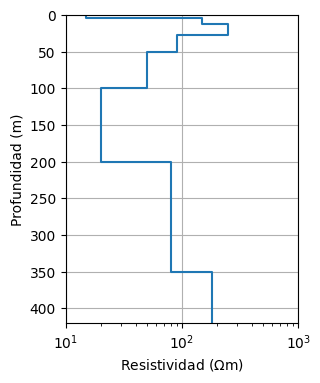

In [ ]:
#layer_tops = np.r_[0., -synTHK.numpy(), -50., -100., -200., -350.]  # in m
rho_layers = [15, 150, 250, 90, 50, 20, 80, 180]
layer_thicknesses = [4, 8, 15, 23, 50, 100, 150]

synthk,synres = layer_thicknesses,rho_layers
fig, ax = plt.subplots(figsize=(3,4))
drawModel1D(ax, layer_thicknesses, rho_layers,plot='semilogx')
plt.xlim([10,10**3])
print(layer_thicknesses)

synthk,synres = layer_thicknesses,rho_layers

In [ ]:
layer_thicknesses_inv = np.concatenate((np.logspace(0.0, 0.9, 15), np.logspace(0.8, 1.96, 9)))

In [ ]:
np.sum(layer_thicknesses_inv)

np.float64(356.83829401111666)

#DLJIneT

In [ ]:
# RED PAUL GOYES
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, concatenate, add

# Function to build the model
def build_model(input_dim_ves, input_dim_mt, output_dim, nc, ly):
    # Define the two input layers: one for the VES data and another for the MT data
    input_layer1 = Input(shape=(input_dim_ves,))  # Input layer for the VES data
    input_layer2 = Input(shape=(input_dim_mt,))   # Input layer for the MT data

    # Concatenate the two input layers into a single layer
    concatenated_inputs = concatenate([input_layer1, input_layer2])

    # First dense layer with ReLU activation
    previous_layer = Dense(nc, activation='relu')(concatenated_inputs)

    # Create hidden layers with residual connections
    for _ in range(ly):
        # Create a dense hidden layer with L1 regularization
        hidden_layer = Dense(nc, activation='relu', kernel_regularizer='l1')(previous_layer)
        # Add the previous layer to the hidden layer (residual connection)
        previous_layer = add([previous_layer, hidden_layer])

    # Output layer with sigmoid activation
    output_layer = Dense(output_dim, activation='sigmoid')(previous_layer)

    # Create the model with the specified inputs and output
    model = keras.Model(inputs=[input_layer1, input_layer2], outputs=output_layer)

    return model

# Define the dimensions of the inputs and output
input_dim_ves = 30  # Dimension of the VES input
input_dim_mt = 31   # Dimension of the MT input
output_dim = 25     # Dimension of the output
nc = 128*2          # Number of neurons in each layer
ly = 2              # Number of hidden layers

# Build the model
DLJIneT = build_model(input_dim_ves, input_dim_mt, output_dim, nc, ly)
DLJIneT.summary()  # Optional: uncomment this line to print the model summary


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 31)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 61)        │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     15,872 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ add[0][0],        │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 25)        │      6,425 │ add_1[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 153,881 (601.10 KB)

 Trainable params: 153,881 (601.10 KB)

 Non-trainable params: 0 (0.00 B)

#VES data

In [ ]:
d_obs = forward2(synres[:5])

synthetic_data_log = tf.cast(tf.math.log(d_obs) / tf.math.log(tf.constant(10.0, dtype=tf.float64)), dtype=tf.float64)

d_obs_scaled = tf.constant(synthetic_data_log, dtype=tf.float64)
d_obs_scaled = tf.reshape(d_obs_scaled, (1, len(synthetic_data_log)))

In [ ]:
d_obs.shape

TensorShape([30])

#MT data

In [ ]:
z_obs = MTforwardModelTF2(synthk, synres)

z_obs = tf.constant(z_obs, dtype=tf.complex128)

z_obs_scaled = tf.reshape(z_obs, (1, len(z_obs)))

#Training algorithm

In [ ]:
from tqdm import trange

# Number of runs (iterations)
num_runs = 30

# Lists to store the predictions from SEV and MT
all_d_pred_VES = []
all_d_pred_MT = []
all_model_pred = []
alpha = 0.8
# Run the model multiple times
for run in range(num_runs):

    # Build the model
    DLJIneT = build_model(input_dim_ves, input_dim_mt, output_dim, nc, ly)
    # Set the optimizer to AdamW with a learning rate of 1e-4
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4)

    # Define the training function using @tf.function for optimization
    @tf.function
    def train():
        with tf.GradientTape() as tape:

            # ------ VES (Vertical Electrical Sounding)

            # Cast the observed data to real before passing to the model
            model_pred = tf.squeeze(DLJIneT([d_obs_scaled, tf.cast(tf.math.real(z_obs_scaled), dtype=tf.float64)], training=True))

            # Scale the model predictions and compute the forward model predictions
            scaled_model_pred = 10 ** (3 * model_pred)
            d_pred = forward(scaled_model_pred[:16])

            # Apply logarithmic transformation to the predictions
            log_d_pred = tf.math.log(d_pred) / tf.math.log(tf.constant(10.0, dtype=tf.float64))

            # Calculate the second part of the loss (difference in model predictions in log space)
            diff = tf.math.subtract(model_pred[1:], model_pred[:-1])
            diff = tf.cast(diff, dtype=tf.float64)
            logspace_tensor = tf.constant(layer_thicknesses_inv, dtype=tf.float64)

            # Compute the loss for the difference
            loss_diff = tf.norm(diff / logspace_tensor, 2)

            # Compute the VES loss
            loss_VES = (0.5) * tf.norm(d_obs_scaled - log_d_pred, ord=2)

            # ------- MT (Magnetotelluric)

            # Cast the observed MT data to real before passing to the model
            res_pred = 10 ** (3 * DLJIneT([d_obs_scaled, tf.abs(tf.cast(tf.math.real(z_obs_scaled), dtype=tf.float64))], training=True))

            # Calculate the MT loss (difference between observed and forward model predictions)
            loss_MT = tf.math.real(0.5*tf.norm(tf.math.log(z_obs_scaled) - tf.math.log(MTforwardModelTF(tf.reshape(res_pred, (-1,)))) ,2))

            # Total loss combining VES, MT, and difference regularization
            loss = (alpha) * loss_VES + (1 - alpha) * loss_MT + loss_diff

        # Compute gradients and apply them to the model's weights
        grads = tape.gradient(loss, DLJIneT.trainable_weights)
        optimizer.apply_gradients(zip(grads, DLJIneT.trainable_weights))

        return loss, loss_VES, loss_MT

    # Initialize lists to store the losses
    loss = []
    loss_VES = []
    loss_MT = []

    # Training loop (300 iterations per run)
    for i in trange(300, desc=f"Run {run+1}/{num_runs}"):
        los = train()
        loss.append(los[0].numpy())
        loss_VES.append(los[1].numpy())
        loss_MT.append(los[2].numpy())

    # Final prediction for this run
    model_pred = 10 ** (3 * tf.squeeze(DLJIneT([d_obs_scaled, tf.abs(tf.cast(tf.math.real(z_obs_scaled), dtype=tf.float64))], training=False)))

    # Calculate d_pred_SEV using the first 16 values of the model prediction
    d_pred_VES = forward(model_pred[:16])

    # Calculate d_pred_MT directly from the model prediction
    d_pred_MT = MTforwardModelTF2(layer_thicknesses_inv, tf.reshape(10 ** (3 * DLJIneT([d_obs_scaled, tf.abs(tf.cast(tf.math.real(z_obs_scaled), tf.float64))], training=False)), (-1,)))

    # Store the predictions for this run
    all_d_pred_VES.append(d_pred_VES.numpy())
    all_d_pred_MT.append(d_pred_MT.numpy())
    all_model_pred.append(model_pred.numpy())

# After completing the runs, you have the predictions for SEV and MT from all 30 models

Run 30/30: 100%|██████████| 300/300 [00:45<00:00,  6.66it/s]


#View predictions

/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


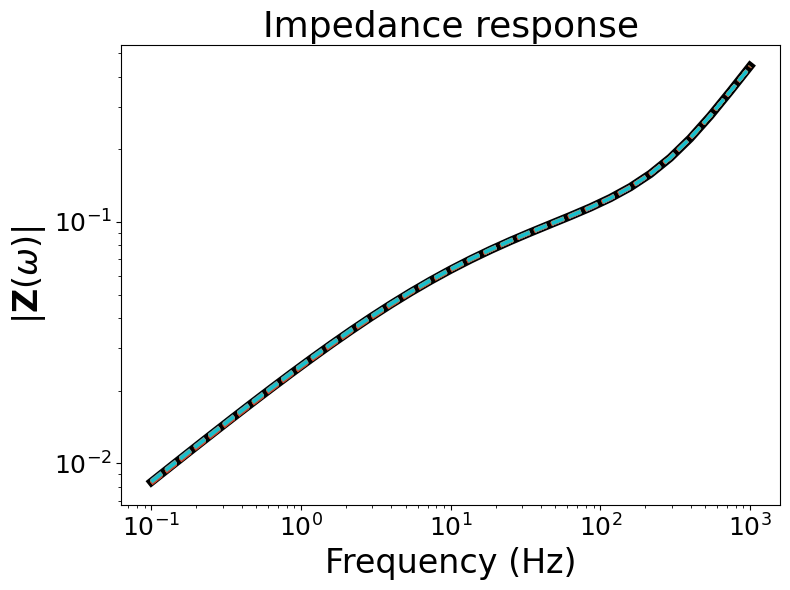

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.loglog(np.logspace(-1, 3, 31), z_obs, 'k', label='Observed', linewidth=6)

# Plot the MT results for all runs
for run in range(num_runs):
    # Plot the MT results for the current run using dashed lines
    ax.loglog(np.logspace(-1, 3, 31), tf.reshape(all_d_pred_MT[run], (-1,)),
              '--', label=f'Proposed Run {run+1}', linewidth=2.5)

ax.set_ylabel("$|\mathbf{Z}(\omega)|$", fontsize=24)  # Y-axis label (impedance)
ax.set_xlabel("Frequency (Hz)", fontsize=24)  # X-axis label (frequency)

ax.tick_params(axis='both', labelsize=18)

plt.title('Impedance response', fontsize=26)

# Adjust the layout to avoid clipping of labels
plt.tight_layout()

# Save the plot as a PNG file with high resolution
plt.savefig('impedance_response_all_runs.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


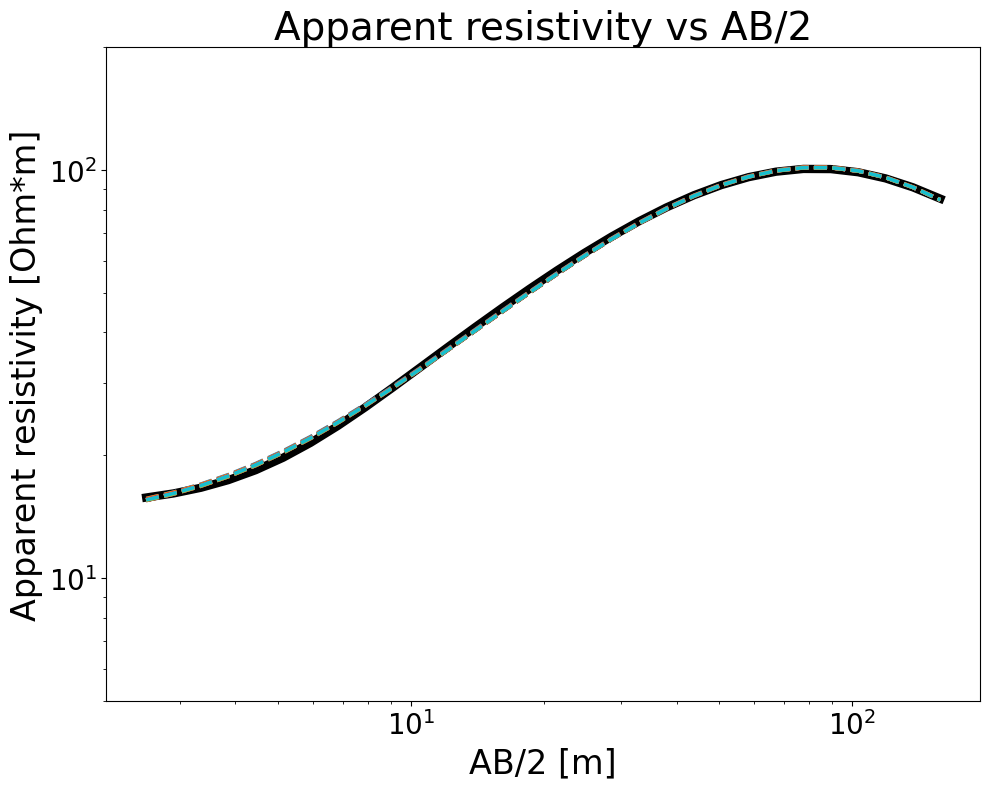

In [ ]:
ab2 = tf.cast(np.logspace(0.4, 2.2, 30), dtype=tf.float64)

# Create the main plot
fig, ax_main = plt.subplots(figsize=(10, 8))

# Plot the observed data (just once) with a black line
ax_main.plot(ab2, d_obs, linestyle='-', label='Observed', color='black', linewidth=6)

# Plot the VES predictions for all runs
for run in range(num_runs):
    # Plot the VES predictions for the current run using dashed lines
    ax_main.plot(ab2, all_d_pred_VES[run], linestyle='--', label=f'Proposed Run {run+1}', linewidth=2.5)

# Configure axis limits and labels
ax_main.set_ylim(5, 200)  # Set y-axis limits (log scale)
ax_main.set_yscale('log')  # Use log scale for y-axis
ax_main.set_xscale('log')  # Use log scale for x-axis
ax_main.set_xlabel('AB/2 [m]', fontsize=24)  # Label for x-axis
ax_main.set_ylabel('Apparent resistivity [Ohm*m]', fontsize=24)  # Label for y-axis
ax_main.set_title('Apparent resistivity vs AB/2', fontsize=28)  # Title of the plot
ax_main.tick_params(axis='both', which='major', labelsize=20)  # Set font size for axis labels
#ax_main.legend(fontsize=20, loc='lower right')  # Set font size for legend and position it

# Add grid (disabled)
ax_main.grid(False)

# Adjust layout to avoid clipping of labels and title
plt.tight_layout()

# Save the plot as a PNG image with high resolution (300 dpi)
plt.savefig('apparent_resistivity_vs_ab2_all_runs.png', format='png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


#1D model obtained

Total number of models: 30
Predictions for Model 1: [ 13.917894  15.248933  21.611639  36.134766  62.63417  105.318825
 162.99756  225.73335  272.07556  279.471    245.57945  189.83627
 134.49857   91.71528   63.270927  45.128906  45.960148  45.55478
  41.101505  29.010489  19.363829  18.54269   95.85764   83.49311
 181.57083 ]
Predictions for Model 2: [ 13.76566   15.043143  21.260708  35.88627   62.60717  105.32316
 163.38771  226.40576  272.50726  279.6788   245.58162  188.70578
 133.37923   90.65475   62.384335  45.158165  44.56969   43.52372
  40.95969   33.62594   17.73476   17.574923 198.01695   70.42194
 179.16669 ]
Predictions for Model 3: [ 13.809663  15.052231  21.328611  35.902645  62.776585 105.655685
 163.85976  227.52328  274.70035  282.77798  248.09201  189.28557
 131.08112   87.34282   59.37729   45.69024   43.67928   42.316284
  42.844418  41.1416    15.14238   19.506577 186.82655   67.163055
 179.01823 ]
Predictions for Model 4: [ 13.829324  15.132516  21.493238  35.

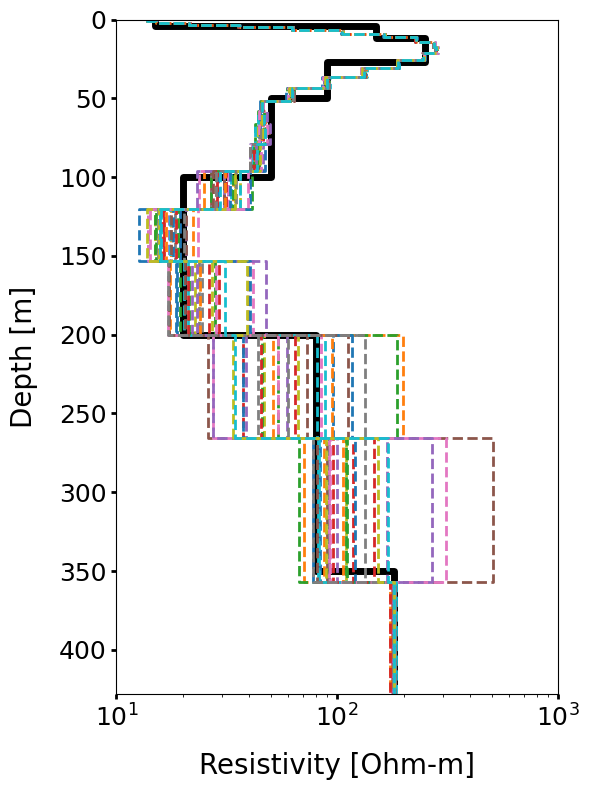

In [ ]:
# Ensure that predictions are available
print(f"Total number of models: {len(all_model_pred)}")

# We assume that num_runs is equal to the number of trained models
num_runs = 30 # Adjust as needed

# Create the main plot
fig, ax = plt.subplots(figsize=(6, 8))  # Slightly larger for better clarity

# Plot the true model (you should have your real data here)
drawModel1D(ax, synthk, synres, color='black', label='True', linewidth=5)  # Black line with thicker width

# Plot predictions from all models
for run in range(num_runs):
    # Check the predictions before plotting
    model_pred = all_model_pred[run]  # Directly access the corresponding model

    # If the model is in TensorFlow tensor format, convert it to numpy
    if isinstance(model_pred, tf.Tensor):
        model_pred = model_pred.numpy()

    # Check if predictions are correct
    print(f"Predictions for Model {run+1}: {model_pred}")

    # Plot the predicted model with a red dashed line
    drawModel1D(ax, layer_thicknesses_inv, model_pred, linestyle='--', label=f'Model {run+1} Predicted', linewidth=2.0)

# Configure the plot
ax.set_xscale('log')  # Set the x-axis to a logarithmic scale
ax.set_xlabel('Resistivity [Ohm-m]', fontsize=20, labelpad=15)  # x-axis label with extra padding
ax.set_ylabel('Depth [m]', fontsize=20, labelpad=15)  # y-axis label with extra padding
ax.tick_params(axis='both', which='major', labelsize=18, width=2)  # Increase label size and line width

# Adjust the legend
#ax.legend(fontsize=15, loc='center left', frameon=True, framealpha=0.7, edgecolor='black', title_fontsize=14)

# Limit the values on the x-axis
plt.xlim([10, 10**3])

# Add subtle gridlines for better readability
ax.grid(False)

# Improve margins and layout
plt.tight_layout()

# Save the plot as a PNG file with high resolution (300 dpi)
plt.savefig('inverted_model_comparison_all_runs.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Code to download the file (if used in an environment like Google Colab)
# from google.colab import files
# files.download('inverted_model_comparison_all_runs.png')


In [ ]:
import numpy as np

# Assuming all_model_pred has shape (n_models, n_predictions)
all_model_pred = np.array(all_model_pred)

# Compute uncertainty (standard deviation) at each prediction index
uncertainty = np.std(all_model_pred, axis=0)

# Compute total uncertainty for each model (sum of its standard deviations)
total_uncertainty_per_model = np.std(all_model_pred, axis=1)  # Correction here

# Find the index of the model with the lowest total uncertainty
min_uncertainty_idx = np.argmin(total_uncertainty_per_model)

# Select the prediction values from the model with the lowest uncertainty
selected_model = all_model_pred[min_uncertainty_idx, :]

# Compute the average model (mean of predictions from all models)
average_model = np.mean(all_model_pred, axis=0)

# Display results
print("Uncertainty at each prediction point:", uncertainty)
print("Model selected with lowest total uncertainty:", selected_model)
print("Index of selected model:", min_uncertainty_idx)
print("Average model:", average_model)

Incertidumbre en cada predicción: [5.0766312e-02 4.6132389e-02 6.9136292e-02 1.0643608e-01 1.9844502e-01
 3.6336958e-01 6.6031086e-01 9.6845901e-01 1.6808695e+00 2.1382968e+00
 1.4230294e+00 1.0730367e+00 1.7923213e+00 1.8881680e+00 1.2730020e+00
 2.9729185e-01 1.0951140e+00 1.8004400e+00 1.6356751e+00 4.5273581e+00
 2.5671840e+00 8.1684084e+00 4.2729694e+01 8.7995743e+01 2.3418510e+00]
Modelo seleccionado con menor incertidumbre total: [ 13.802971  15.095013  21.422112  36.052494  62.780167 105.40819
 163.42154  226.18004  270.71066  279.00867  243.47539  188.57892
 134.16502   92.252975  63.450256  45.144073  47.231556  47.990044
  41.009323  23.744623  23.407625  17.14049   84.43064   91.453026
 177.52225 ]
Índice del modelo seleccionado: 16
Modelo promedio: [ 13.815072  15.085315  21.377586  35.899845  62.763237 105.5989
 163.67766  226.93698  273.1496   280.32126  245.30351  188.19522
 132.63019   90.260796  62.24851   45.402428  45.801495  45.66592
  42.54603   31.413984  17.0820

In [ ]:
# Compute uncertainty per layer (standard deviation across models)
uncertainty_per_layer = np.std(all_model_pred, axis=0)

# Convert to list
uncertainty_per_layer_list = uncertainty_per_layer.tolist()

# Display the list
print("Uncertainty per layer:", uncertainty_per_layer_list)

selected_model = all_model_pred[min_uncertainty_idx, :]
pred_and_unc_list = list(zip(selected_model.tolist(), uncertainty_per_layer_list))

print("List of (prediction, uncertainty):")
print(pred_and_unc_list)

Incertidumbre por capa: [0.05076631158590317, 0.04613238945603371, 0.06913629174232483, 0.10643608123064041, 0.19844502210617065, 0.36336958408355713, 0.6603108644485474, 0.9684590101242065, 1.680869460105896, 2.1382968425750732, 1.4230294227600098, 1.0730366706848145, 1.7923213243484497, 1.8881679773330688, 1.273002028465271, 0.2972918450832367, 1.09511399269104, 1.8004399538040161, 1.635675072669983, 4.527358055114746, 2.5671839714050293, 8.168408393859863, 42.72969436645508, 87.99574279785156, 2.341850996017456]
Lista de (predicción, incertidumbre):
[(13.802970886230469, 0.05076631158590317), (15.095012664794922, 0.04613238945603371), (21.42211151123047, 0.06913629174232483), (36.052494049072266, 0.10643608123064041), (62.78016662597656, 0.19844502210617065), (105.40818786621094, 0.36336958408355713), (163.42153930664062, 0.6603108644485474), (226.18003845214844, 0.9684590101242065), (270.7106628417969, 1.680869460105896), (279.0086669921875, 2.1382968425750732), (243.4753875732422,

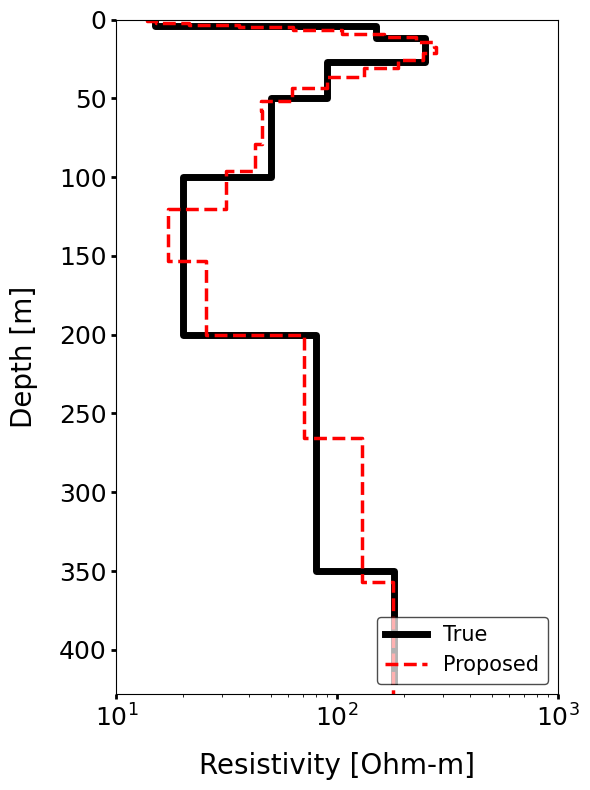

In [ ]:
fig, ax = plt.subplots(figsize=(6, 8))

drawModel1D(ax, synthk, synres, color='black', label='True', linewidth=5)

drawModel1D(ax, layer_thicknesses_inv, average_model, color='red', linestyle='--', label='Proposed', linewidth=2.5)



ax.set_xscale('log')
ax.set_xlabel('Resistivity [Ohm-m]', fontsize=20, labelpad=15)
ax.set_ylabel('Depth [m]', fontsize=20, labelpad=15)
ax.tick_params(axis='both', which='major', labelsize=18, width=2)
ax.legend(fontsize=15, loc='lower right', frameon=True, framealpha=0.7, edgecolor='black', title_fontsize=14)
plt.xlim([10, 10**3])
ax.grid(False)
plt.tight_layout()
plt.savefig('inverted_model_comparison.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

# from google.colab import files
# files.download('inverted_model_comparison.png')


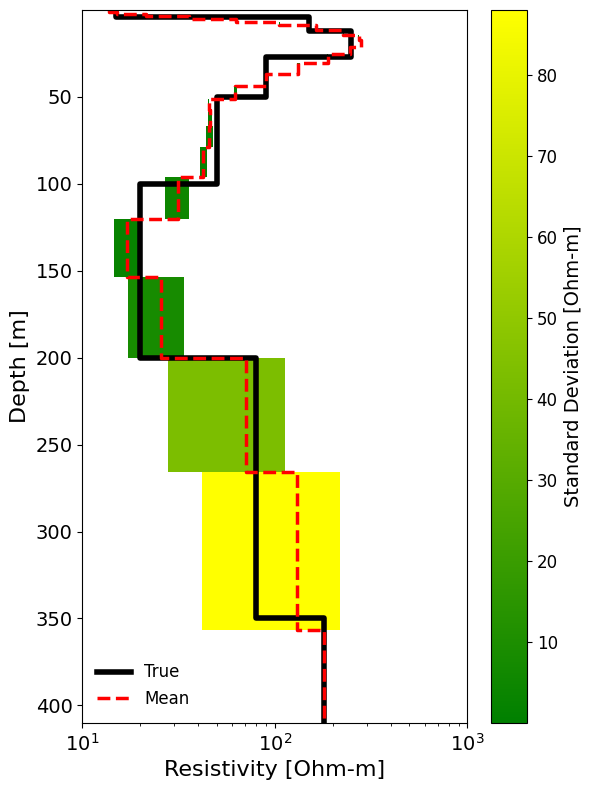

In [ ]:
import matplotlib.colors as mcolors

all_model_pred = np.array(all_model_pred)
thickness      = np.array(layer_thicknesses_inv)

mean_pred = np.mean(all_model_pred, axis=0)
std_pred  = np.std(all_model_pred, axis=0)

# Compute depth edges based on cumulative layer thickness
edges = np.concatenate(([0], np.cumsum(thickness)))

# Define colormap: Green (#008000) → Yellow (#FFFF00)
colors = ["#008000", "#FFFF00"]
cmap = mcolors.LinearSegmentedColormap.from_list("GreenYellow", colors)

fig, ax = plt.subplots(figsize=(6, 8))

for i in range(len(thickness)):
    y0, y1 = edges[i], edges[i+1]

    # Normalize standard deviation value to [0, 1] for colormap indexing
    std_min, std_max = np.min(std_pred), np.max(std_pred)
    color_idx = (std_pred[i] - std_min) / (std_max - std_min)
    color = cmap(color_idx)

    # Plot the uncertainty range as a filled region for each layer
    ax.fill_betweenx([y0, y1], mean_pred[i] - std_pred[i], mean_pred[i] + std_pred[i],
                     color=color, alpha=1.0, edgecolor='none')

# Plot true model
drawModel1D(ax, synthk, synres, color='black', label='True', linewidth=4)

# Plot mean predicted model
drawModel1D(ax, layer_thicknesses_inv, average_model, color='red', linestyle='--', label='Mean', linewidth=2.5)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('Resistivity [Ohm-m]', fontsize=16)
ax.set_ylabel('Depth [m]', fontsize=16)
ax.tick_params(labelsize=14)
ax.legend(loc='lower left', fontsize=12, frameon=False)
ax.grid(False)
plt.xlim([10, 10**3])
plt.ylim([10**-1, 410])
ax.invert_yaxis()

# Add colorbar for standard deviation
norm = mcolors.Normalize(vmin=std_min, vmax=std_max)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('Standard Deviation [Ohm-m]', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

In [ ]:
print(std_pred)

[5.0766312e-02 4.6132389e-02 6.9136292e-02 1.0643608e-01 1.9844502e-01
 3.6336958e-01 6.6031086e-01 9.6845901e-01 1.6808695e+00 2.1382968e+00
 1.4230294e+00 1.0730367e+00 1.7923213e+00 1.8881680e+00 1.2730020e+00
 2.9729185e-01 1.0951140e+00 1.8004400e+00 1.6356751e+00 4.5273581e+00
 2.5671840e+00 8.1684084e+00 4.2729694e+01 8.7995743e+01 2.3418510e+00]


#Only MT inversion

In [ ]:
def build_model(input_dim, output_dim, nc, ly):
    #regout = OuterLayer()
    # Define the input layer



    input_layer = Input(shape=(input_dim,))
    #previous_layer = input_layer
    previous_layer = Dense(nc, activation='relu')(input_layer)
    # Initialize a list to hold the hidden layers tf.keras.layers.LeakyReLU()
    hidden_layers = []

    # Create the hidden layers
    for _ in range(ly):
        hidden_layer = Dense(nc, activation='relu',kernel_regularizer='l1')(previous_layer)
        hidden_layers.append(hidden_layer)
        previous_layer = keras.layers.add([previous_layer, hidden_layer])  # Sum with the previous layer

    # Add the output layer
    output_layer = Dense(output_dim, activation='sigmoid')(previous_layer)
    #out = regout([output_layer,input_layer])

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=output_layer)

    return model

# Example usage:
input_dim = 31  # Adjust based on your input size
output_dim = 25  # Adjust based on your output size
nc = 128*2  # Number of channels per layer
ly = 2  # Number of layers

MTaeNET = build_model(input_dim, output_dim, nc, ly)

# Compile the model as needed
#model.compile(optimizer='adam', loss='mean_squared_error')  # Adjust the loss and optimizer as needed


#tf.keras.utils.plot_model(MTaeNET,show_shapes=True)
MTaeNET.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_62      │ (None, 31)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_124 (Dense)   │ (None, 256)       │      8,192 │ input_layer_62[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_125 (Dense)   │ (None, 256)       │     65,792 │ dense_124[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_62 (Add)        │ (None, 256)       │          0 │ dense_124[0][0],  │
│                     │                   │            │ dense_125[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_126 (Dense)   │ (None, 256)       │     65,792 │ add_62[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_63 (Add)        │ (None, 256)       │          0 │ add_62[0][0],     │
│                     │                   │            │ dense_126[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_127 (Dense)   │ (None, 25)        │      6,425 │ add_63[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 146,201 (571.10 KB)

 Trainable params: 146,201 (571.10 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
initial_learning_rate = 1e-3
optimizern = tf.keras.optimizers.AdamW(learning_rate=initial_learning_rate)

@tf.function
def trainDL():

  with tf.GradientTape() as tape:
    res_pred = 10**(3*MTaeNET(tf.reshape(tf.abs(z_obs),(1,-1)), training=True))
    #modelreg = tf.cast(1e-3*tf.norm( tf.cast(tf.math.log(L2model),tf.float64)-tf.cast(tf.math.log(tf.reshape(res_pred,(-1,))),tf.float64)  ,2 ),dtype=tf.float64 )
    loss = tf.math.real(0.5*tf.norm(tf.math.log(z_obs) - tf.math.log(MTforwardModelTF2(layer_thicknesses_inv,tf.reshape(res_pred,(-1,)))) ,2)) #+ modelreg

  grads = tape.gradient(loss, MTaeNET.trainable_weights)
  optimizern.apply_gradients(zip(grads, MTaeNET.trainable_weights))

  return loss
  #print(res_pred)

In [ ]:
from tqdm import trange
loss = []
pbar = trange(300)
for i in pbar:
  los = trainDL()
  pbar.set_postfix(LOSS=los.numpy())
  loss.append(los.numpy())

100%|██████████| 300/300 [00:33<00:00,  8.87it/s, LOSS=0.0118]


In [ ]:
res_pred = 10**(3*MTaeNET(tf.reshape(tf.abs(z_obs),(1,-1)), training=False))
res_pred

<tf.Tensor: shape=(1, 25), dtype=float32, numpy=
array([[ 42.296196,  53.3866  ,  29.89766 ,  38.531765,  40.85228 ,
         70.17638 ,  64.57447 ,  83.87382 ,  60.560555,  72.13154 ,
         67.58654 ,  98.53434 ,  77.653076,  71.18897 ,  83.48929 ,
         87.31286 ,  91.06956 ,  77.99213 ,  44.904648,  22.300936,
         17.885517,  21.820469,  72.50369 ,  86.779366, 182.61557 ]],
      dtype=float32)>

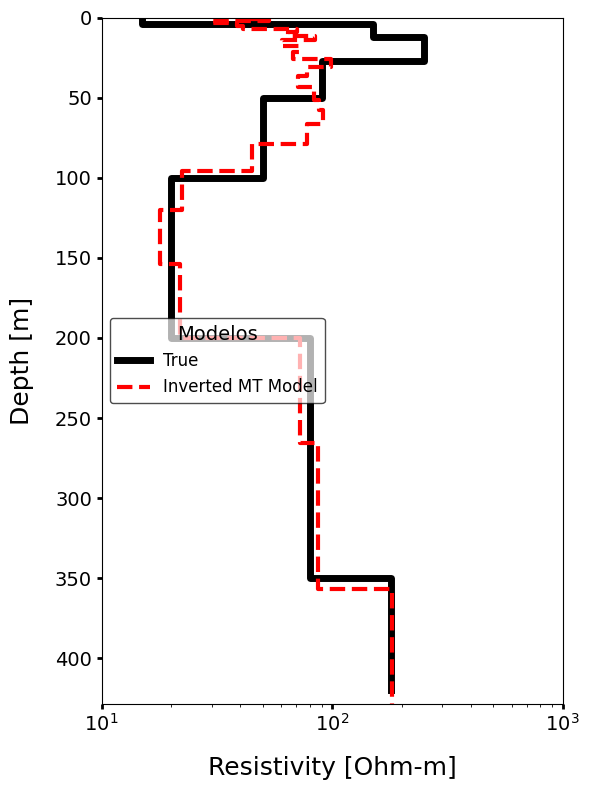

In [ ]:
fig, ax = plt.subplots(figsize=(6, 8))

drawModel1D(ax, synthk, synres, color='black', label='True', linewidth=5)

drawModel1D(ax, layer_thicknesses_inv, res_pred.numpy().flatten(), color='red', linestyle='--', label='Inverted MT Model', linewidth=3)

ax.set_xscale('log')
ax.set_xlabel('Resistivity [Ohm-m]', fontsize=18, labelpad=15)
ax.set_ylabel('Depth [m]', fontsize=18, labelpad=15)
ax.tick_params(axis='both', which='major', labelsize=14, width=2)

ax.legend(fontsize=12, loc='center left', frameon=True, framealpha=0.7, edgecolor='black', title='Modelos', title_fontsize=14)

plt.xlim([10, 10**3])

ax.grid(False)

plt.tight_layout()

plt.savefig('inverted_model_comparison.png', format='png', dpi=300, bbox_inches='tight')

plt.show()


# from google.colab import files
# files.download('inverted_model_comparison.png')


#SIMPEG MT model

In [ ]:
m_simpeg = [-5.1938641 , -4.52596662, -4.10086807, -3.18693882, -2.73968316,
       -3.35712889, -3.86209116, -4.13185885, -4.25723509, -4.32508802,
       -4.35786489, -4.3465071 , -4.3092236 , -4.25923285, -4.20568396,
       -4.15448265, -4.10903729, -4.07092674, -4.04047674, -4.01723066,
       -4.00030876, -3.98866216, -3.98123696, -3.97706852, -3.97519754]

m_true_simpeg = (1./(np.exp(m_simpeg)))[::-1]

print(m_true_simpeg)

[ 53.26063697  53.36037984  53.58327362  53.98262092  54.61501036
  55.54706392  56.85344065  58.61125482  60.88807179  63.718991
  67.06645275  70.75568241  74.38271578  77.20831048  78.09022508
  75.57216443  70.61447064  62.29360986  47.56471287  28.70665249
  15.48207898  24.21418988  60.39268993  92.38518405 180.16337894]


#Comparison of inverted models

In [ ]:
resipi =  tf.constant([15.03, 185.9, 51.19], dtype = tf.float64)
thkipi = tf.constant([4.098, 34.81], dtype = tf.float64)

In [ ]:
respygimli = [15.176864538439673, 12.326591097098259, 20.49391263043692, 43.68310157017679, 84.47813369894783,
              137.7182486464248, 189.66519379105003, 224.52780318280114, 233.20043931918326, 217.28348462915758,
              185.9936100790867, 149.90634681695087, 116.53157510085994, 89.32578702273102, 68.8124797931635, 54.07950516557639]


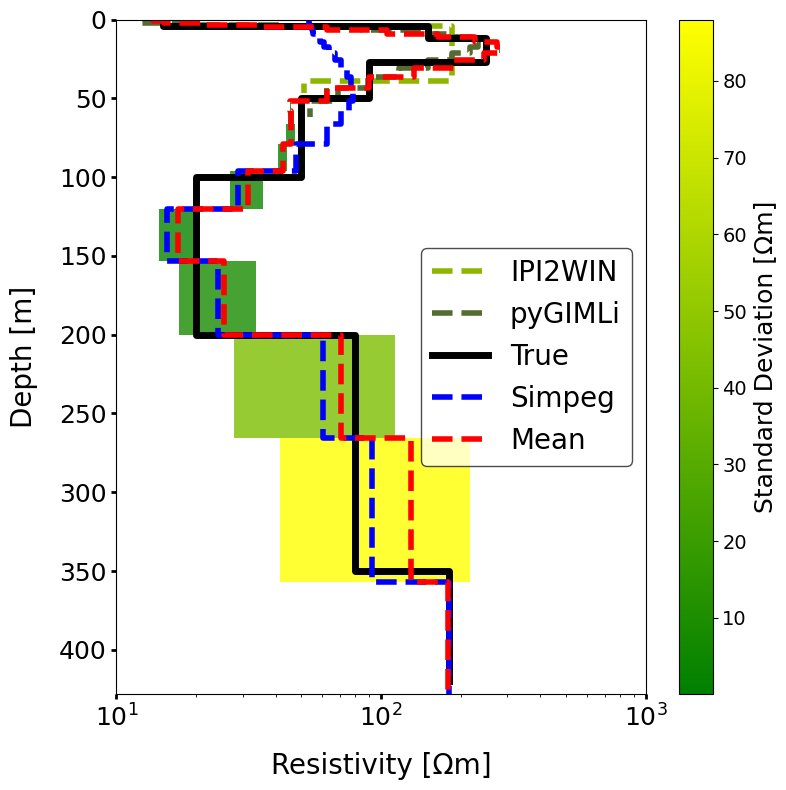

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.colors as mcolors


# Ensure arrays are properly formatted
all_model_pred = np.array(all_model_pred)
thickness = np.array(layer_thicknesses_inv)

# Compute mean and standard deviation across ensemble predictions
mean_pred = np.mean(all_model_pred, axis=0)
std_pred = np.std(all_model_pred, axis=0)

# Calculate layer boundaries
edges = np.concatenate(([0], np.cumsum(thickness)))

# Define custom colormap from green to yellow
colors = ["#008000", "#FFFF00"]  # Green to Yellow
cmap = mcolors.LinearSegmentedColormap.from_list("GreenYellow", colors)
std_min, std_max = np.min(std_pred), np.max(std_pred)
norm = mcolors.Normalize(vmin=std_min, vmax=std_max)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Draw uncertainty bands (±1 std) using fill_betweenx for each layer
for i in range(len(thickness)):
    y0, y1 = edges[i], edges[i+1]
    color_idx = (std_pred[i] - std_min) / (std_max - std_min)
    color = cmap(color_idx)

    ax.fill_betweenx([y0, y1], mean_pred[i] - std_pred[i], mean_pred[i] + std_pred[i],
                     color=color, alpha=0.8, edgecolor='none')

# Plot the different resistivity models
drawModel1D(ax, thickness=thkipi, values=resipi, plot='semilogx', color='#8DB600', linestyle='dashed', label='IPI2WIN', linewidth=4.0)
drawModel1D(ax, layer_thicknesses_inv[:16], values=respygimli, plot='semilogx', color='#556B2F', linestyle='dashed', label='pyGIMLi', linewidth=4.0)
drawModel1D(ax, synthk, synres, color='black', label='True', linewidth=5.0)
drawModel1D(ax, layer_thicknesses_inv, m_true_simpeg, color='blue', linestyle='--', label='Simpeg', linewidth=4.0)
drawModel1D(ax, layer_thicknesses_inv, mean_pred, color='red', linestyle='--', label='Mean', linewidth=4.0)

# Configure axis labels and style
ax.set_xscale('log')
ax.set_xlabel('Resistivity [Ωm]', fontsize=20, labelpad=15)
ax.set_ylabel('Depth [m]', fontsize=20, labelpad=15)
ax.tick_params(axis='both', which='major', labelsize=18, width=2)

# Legend configuration
ax.legend(fontsize=20, loc='center right', frameon=True, framealpha=0.7, edgecolor='black', title_fontsize=14)

# Set x and y axis limits
plt.xlim([10, 10**3])

# Disable grid for cleaner look
ax.grid(False)

# Add colorbar indicating uncertainty magnitude
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('Standard Deviation [Ωm]', fontsize=18)
cbar.ax.tick_params(labelsize=14)

# Final layout adjustments and export
plt.tight_layout()
plt.savefig('inverted_model_comparison.svg', format='svg', bbox_inches='tight')
plt.show()
from google.colab import files
files.download('inverted_model_comparison.svg')


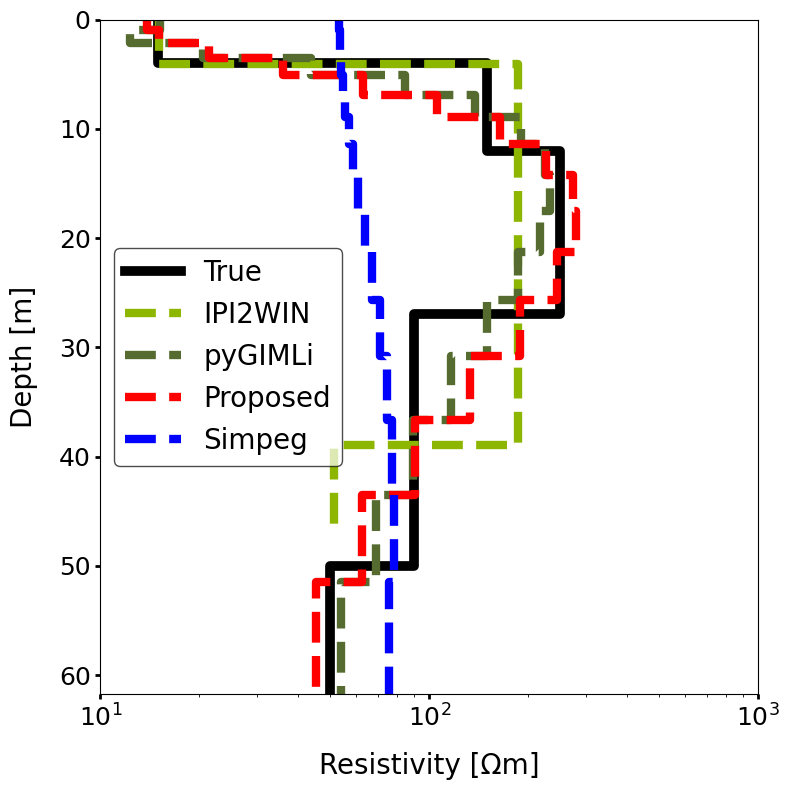

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

drawModel1D(ax, synthk, synres, color='black', label='True', linewidth=7.0)
#drawModel1D(ax, layer_thicknesses_inv, m_true_simpeg, color='blue', linestyle='--', label='MT simpeg', linewidth=4)
#drawModel1D(ax, layer_thicknesses_inv, res_pred.numpy().flatten(), color='yellow', linestyle='--', label='Inverted MT Model', linewidth=3)
#drawModel1D(ax, layer_thicknesses_inv[:16], model_predd[:16], color='orange', linestyle='--', label='DL VES', linewidth=4.0)

drawModel1D(ax, thickness=thkipi, values=resipi, plot='semilogx', color='#8DB600', linestyle='dashed', label='IPI2WIN', linewidth=6.0)
drawModel1D(ax, layer_thicknesses_inv[:16], values=respygimli, plot='semilogx', color='#556B2F', linestyle='dashed', label='pyGIMLi', linewidth=6.0)
drawModel1D(ax, layer_thicknesses_inv, average_model[:16], color='red', linestyle='--', label='Proposed', linewidth=6.0)
drawModel1D(ax, layer_thicknesses_inv,  m_true_simpeg[:16], color='blue', linestyle='--', label='Simpeg', linewidth=6.0)



ax.set_xscale('log')
ax.set_xlabel('Resistivity [Ωm]', fontsize=20, labelpad=15)
ax.set_ylabel('Depth [m]', fontsize=20, labelpad=15)
ax.tick_params(axis='both', which='major', labelsize=18, width=2)

ax.legend(fontsize=20, loc='center left', frameon=True, framealpha=0.7, edgecolor='black', title_fontsize=14)

plt.xlim([10, 10**3])

ax.grid(False)

plt.tight_layout()

plt.savefig('inverted_model_comparison_somero.svg', format='svg', bbox_inches='tight')

plt.show()
from google.colab import files
files.download('inverted_model_comparison_somero.svg')


#Predictions

In [ ]:
@tf.function
def forward3(res, thk):
    res = tf.cast(res, tf.float64)
    ab2 = tf.cast(np.logspace(0.4, 2.2, 30), dtype=tf.float64)
    lays = tf.shape(res)[0] - 1
    thick = tf.cast(thk, dtype=tf.float64)

    LOG = tf.math.log(tf.cast(10.0, dtype=tf.float64))
    COUNTER = 1 + (2 * 13 - 2)
    UP = tf.exp(0.5 * LOG / 4.438)

    up = ab2 * tf.exp(-10.0 * LOG / 4.438)
    ti = tf.TensorArray(dtype=tf.float64, size=COUNTER)

    for ii in range(COUNTER):
        ti1 = tf.fill(tf.shape(up), res[lays])

        lay = lays
        while lay > 0:
            lay -= 1
            tan_h = tf.tanh(thick[lay] / up)
            ti1 = (ti1 + res[lay] * tan_h) / (1 + ti1 * tan_h / res[lay])

        ti = ti.write(ii, ti1)
        up *= UP

    ti = ti.stack()

    weights = tf.constant([105, 0, -262, 0, 416, 0, -746, 0, 1605, 0, -4390, 0, 13396, 0, -27841,
                           0, 16448, 0, 8183, 0, 2525, 0, 336, 0, 225], dtype=tf.float64)
    weighted_ti = tf.tensordot(weights, ti, axes=1)
    res_a = weighted_ti / 1e4

    return res_a

/tmp/ipython-input-42-801665087.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


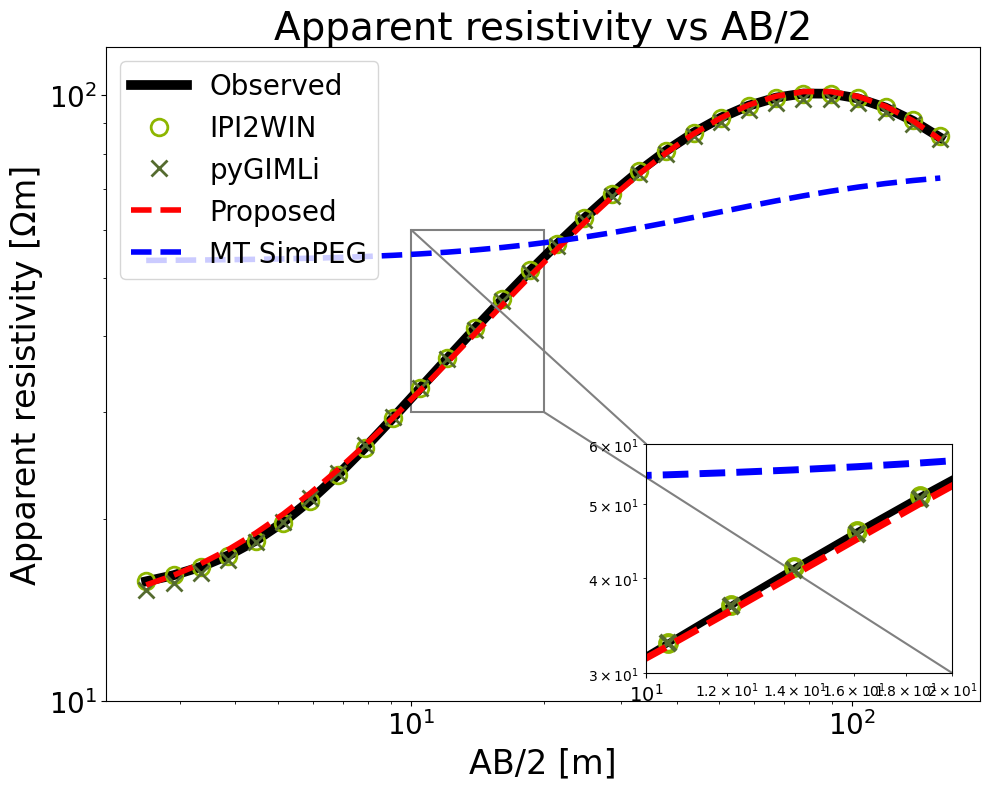

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

ab2 = tf.cast(np.logspace(0.4, 2.2, 30), dtype=tf.float64)

# Create the main plot
fig, ax_main = plt.subplots(figsize=(10, 8))

# Plot the observed data (black line)
ax_main.plot(ab2, d_obs, linestyle='-', label='Observed', color='black', linewidth=7.0)

# Plot the VES predictions with different markers
ax_main.plot(ab2, forward3(resipi, thkipi), linestyle='None', marker='o', markersize=12,
             markeredgewidth=2.0, label='IPI2WIN', color='#8DB600', markerfacecolor='none')  # Verde manzana

ax_main.plot(ab2, forward(respygimli), linestyle='None', marker='x', markersize=12,
             markeredgewidth=2.0, label='pyGIMLi', color='#556B2F')  # Verde oliva

ax_main.plot(ab2, forward(average_model[:16]), linestyle='--', label='Proposed',
             linewidth=4.0, color='red')

ax_main.plot(ab2, forward(m_true_simpeg[:16]), linestyle='--', label='MT SimPEG',
             linewidth=4.0, color='blue')

# Configure axis limits and labels
ax_main.set_ylim(10, 120)
ax_main.set_yscale('log')
ax_main.set_xscale('log')
ax_main.set_xlabel('AB/2 [m]', fontsize=24)
ax_main.set_ylabel('Apparent resistivity [Ωm]', fontsize=24)
ax_main.set_title('Apparent resistivity vs AB/2', fontsize=28)
ax_main.tick_params(axis='both', which='major', labelsize=20)
ax_main.legend(fontsize=20, loc='upper left')
ax_main.grid(False)

# Add zoomed inset in the center of the plot
axins = inset_axes(ax_main, width="35%", height="35%", loc='lower right', borderpad=2)

# Plot same data in the inset
axins.plot(ab2, d_obs, linestyle='-', color='black', linewidth=5.0)
axins.plot(ab2, forward3(resipi, thkipi), linestyle='None', marker='o', markersize=12,
           markeredgewidth=3.0, color='#8DB600', markerfacecolor='none')
axins.plot(ab2, forward(respygimli), linestyle='None', marker='x', markersize=12,
           markeredgewidth=3.0, color='#556B2F')
axins.plot(ab2, forward(average_model[:16]), linestyle='--', linewidth=5.0, color='red')
axins.plot(ab2, forward(m_true_simpeg[:16]), linestyle='--', linewidth=5.0, color='blue')

# Zoom range (center area)
axins.set_xlim(10, 20)
axins.set_ylim(30, 60)
axins.set_yscale('log')
axins.set_xscale('log')
axins.tick_params(axis='both', which='major', labelsize=14)
axins.grid(False)

# Draw lines indicating the zoomed area
mark_inset(ax_main, axins, loc1=2, loc2=4, fc="none", ec="0.5", lw=1.5)

plt.tight_layout()
plt.savefig('apparent_resistivity_vs_ab2.svg', format='svg', bbox_inches='tight')
plt.show()



from google.colab import files
files.download('apparent_resistivity_vs_ab2.svg')

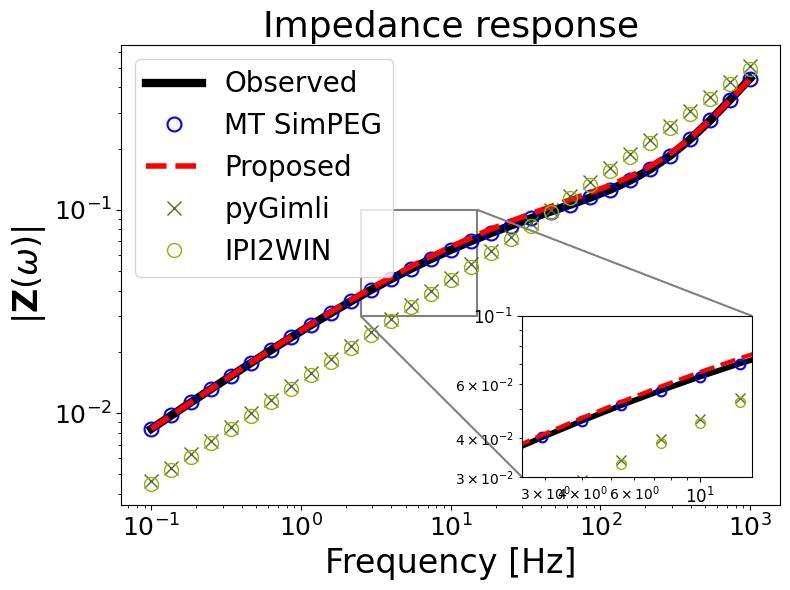

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Crear el gráfico principal
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

frequencies = np.logspace(-1, 3, 31)

# Graficar datos observados
ax.loglog(frequencies, z_obs, 'k', label='Observed', linewidth=6)

# MT SimPEG
ax.loglog(frequencies,
          MTforwardModelTF2(layer_thicknesses_inv, tf.reshape(m_true_simpeg, (-1,))),
          linestyle='None', marker='o', markerfacecolor='none', markersize=10,
          markeredgewidth=1.5, label='MT SimPEG', color='blue')

# Proposed
ax.loglog(frequencies,
          MTforwardModelTF2(layer_thicknesses_inv, tf.reshape(average_model, (-1,))),
          '--', label='Proposed', linewidth=4.0, color='red')

# pyGIMLi
ax.loglog(frequencies,
          MTforwardModelTF2(layer_thicknesses_inv[:15], tf.reshape(respygimli, (-1,))),
          linestyle='None', label='pyGimli', marker='x', markersize=10, color='#556B2F')

# IPI2WIN
ax.loglog(frequencies,
          MTforwardModelTF2(thkipi, tf.reshape(resipi, (-1,))),
          linestyle='None', label='IPI2WIN', marker='o', markerfacecolor='none',
          markersize=10, color='#8DB600')

# Etiquetas y título
ax.set_ylabel("$|\mathbf{Z}(\omega)|$", fontsize=24)
ax.set_xlabel("Frequency [Hz]", fontsize=24)
ax.tick_params(axis='both', labelsize=18)
plt.title('Impedance response', fontsize=26)
plt.legend(fontsize=20, loc='upper left')
plt.tight_layout()

# Crear zoom (inset) centrado
axins = inset_axes(ax, width="35%", height="35%", loc='lower right', borderpad=2)

# Graficar en el inset
axins.loglog(frequencies, z_obs, 'k', linewidth=4)
axins.loglog(frequencies,
             MTforwardModelTF2(layer_thicknesses_inv, tf.reshape(m_true_simpeg, (-1,))),
             linestyle='None', marker='o', markerfacecolor='none', markersize=7,
             markeredgewidth=1.5, color='blue')
axins.loglog(frequencies,
             MTforwardModelTF2(layer_thicknesses_inv, tf.reshape(average_model, (-1,))),
             '--', linewidth=3.0, color='red')
axins.loglog(frequencies,
             MTforwardModelTF2(layer_thicknesses_inv[:15], tf.reshape(respygimli, (-1,))),
             linestyle='None', marker='x', markersize=7, color='#556B2F')
axins.loglog(frequencies,
             MTforwardModelTF2(thkipi, tf.reshape(resipi, (-1,))),
             linestyle='None', marker='o', markerfacecolor='none', markersize=7, color='#8DB600')

# Rango de zoom (ajusta según los datos)
axins.set_xlim(2.5, 15.0)   # De 1 a 100 Hz
axins.set_ylim(0.03, 0.1)   # De 1 a 1000 ohm
axins.tick_params(axis='both', labelsize=12)

# Marcar la región del zoom en el gráfico principal
mark_inset(ax, axins, loc1=3, loc2=1, fc="none", ec="0.5", lw=1.5)

# Guardar y mostrar
plt.savefig('impedance_response.svg', format='svg', bbox_inches='tight')
plt.show()


from google.colab import files
files.download('impedance_response.svg')

In [ ]:
print(ab2)
print(d_obs)

tf.Tensor(
[  2.51188643   2.89780372   3.34301197   3.85662042   4.44913785
   5.13268755   5.92125539   6.83097599   7.88046282   9.09118906
  10.48792698  12.09925474  13.95814116  16.10262028  18.57656952
  21.43060752  24.72312976  28.52150339  32.90344562  37.95861386
  43.79044014  50.51824745  58.27969112  67.23357536  77.5631025
  89.47962141 103.22695186 119.08637321 137.38237959 158.48931925], shape=(30,), dtype=float64)
tf.Tensor(
[ 15.75421313  16.12199693  16.64704956  17.38179938  18.38628108
  19.72281305  21.44796213  23.60427972  26.21529744  29.28614094
  32.80927987  36.77218139  41.16270905  45.96937028  51.17589176
  56.75162381  62.64015825  68.74847572  74.93855321  81.02310207
  86.76700052  91.89587013  96.11299601  99.12527443 100.67778623
 100.59453819  98.81976036  95.45051081  90.74886396  85.12309111], shape=(30,), dtype=float64)


In [ ]:
def rmspe(observed, predicted, epsilon=1e-3):
    weights = np.abs(observed) / np.mean(np.abs(observed))
    return np.sqrt(np.mean(weights * ((observed - predicted) / (observed + epsilon)) ** 2)) * 100

# Para VES
rmspe_proposed_ves = rmspe(d_obs, forward(average_model[:16]))
rmspe_ipi2win_ves = rmspe(d_obs,forward3(resipi, thkipi))
rmspe_pygimly_ves = rmspe(d_obs, forward(respygimli))
rmspe_simpeg_ves = rmspe(d_obs, forward3(m_true_simpeg[:16], layer_thicknesses_inv[:15]))

# Para MT
rmspe_proposed_mt = rmspe(np.abs(z_obs), np.abs( MTforwardModelTF2(layer_thicknesses_inv, tf.reshape(average_model, (-1,)))))
rmspe_simpeg = rmspe(np.abs(z_obs), np.abs(MTforwardModelTF2(layer_thicknesses_inv, tf.reshape(m_true_simpeg, (-1,)))))
rmspe_pygimly_mt = rmspe(np.abs(z_obs), np.abs(MTforwardModelTF2(layer_thicknesses_inv[:15], tf.reshape(respygimli, (-1,)))))
rmspe_ipi2win_mt = rmspe(np.abs(z_obs), np.abs(MTforwardModelTF2(thkipi, tf.reshape(resipi, (-1,)))))

print(f"RMSPE (VES - Método propuesto): {rmspe_proposed_ves:.2f}%")
print(f"RMSPE (VES - IPI2Win): {rmspe_ipi2win_ves:.2f}%")
print(f"RMSPE (VES - pyGIMLi): {rmspe_pygimly_ves:.2f}%")
print(f"RMSPE (VES - SimPEG): {rmspe_simpeg_ves:.2f}%")

print(f"RMSPE (MT - Método propuesto): {rmspe_proposed_mt:.2f}%")
print(f"RMSPE (MT - SimPEG): {rmspe_simpeg:.2f}%")
print(f"RMSPE (MT - pyGIMLi): {rmspe_pygimly_mt:.2f}%")
print(f"RMSPE (MT - IPI2Win): {rmspe_ipi2win_mt:.2f}%")

RMSPE (VES - Método propuesto): 1.18%
RMSPE (VES - IPI2Win): 0.26%
RMSPE (VES - pyGIMLi): 1.43%
RMSPE (VES - SimPEG): 64.73%
RMSPE (MT - Método propuesto): 2.17%
RMSPE (MT - SimPEG): 0.24%
RMSPE (MT - pyGIMLi): 18.76%
RMSPE (MT - IPI2Win): 17.16%


In [ ]:
model_true = synres
model_proposed = average_model
model_simpeg = m_true_simpeg
model_pygimli = respygimli
model_ipi2win = resipi

In [ ]:
print(synthk)
print(model_true)
print(layer_thicknesses_inv)
print(model_proposed)
print(model_simpeg)
print(model_pygimli)
print(model_ipi2win)

[4, 8, 15, 23, 50, 100, 150]
[15, 150, 250, 90, 50, 20, 80, 180]
[ 1.          1.15953995  1.34453288  1.55903959  1.80776868  2.09617999
  2.43060443  2.81838293  3.26802759  3.78940853  4.39397056  5.09498438
  5.90783791  6.85037405  7.94328235  6.30957344  8.81048873 12.30268771
 17.17908387 23.98832919 33.49654392 46.77351413 65.31305526 91.20108394]
[ 13.815072  15.085315  21.377586  35.899845  62.763237 105.5989
 163.67766  226.93698  273.1496   280.32126  245.30351  188.19522
 132.63019   90.260796  62.24851   45.402428  45.801495  45.66592
  42.54603   31.413984  17.082018  25.481138  70.578476 129.64409
 179.63565 ]
[ 53.26063697  53.36037984  53.58327362  53.98262092  54.61501036
  55.54706392  56.85344065  58.61125482  60.88807179  63.718991
  67.06645275  70.75568241  74.38271578  77.20831048  78.09022508
  75.57216443  70.61447064  62.29360986  47.56471287  28.70665249
  15.48207898  24.21418988  60.39268993  92.38518405 180.16337894]
[15.176864538439673, 12.3265910970982

In [ ]:
vector_true = [15, 15, 15, 15, 150, 150, 150, 150, 150, 150, 150, 150, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180]
vector_proposed = [13.798534, 15.063537, 15.063537, 21.355122, 35.83686, 35.83686, 62.69807, 105.41741, 105.41741, 163.48195, 163.48195, 163.48195, 226.40927, 226.40927, 226.40927, 272.80634, 272.80634, 272.80634, 279.9728, 279.9728, 279.9728, 279.9728, 245.52092, 245.52092, 245.52092, 245.52092, 188.52834, 188.52834, 188.52834, 188.52834, 188.52834, 132.90512, 132.90512, 132.90512, 132.90512, 132.90512, 132.90512, 90.45728, 90.45728, 90.45728, 90.45728, 90.45728, 90.45728, 90.45728, 62.4092, 62.4092, 62.4092, 62.4092, 62.4092, 62.4092, 62.4092, 62.4092, 45.301365, 45.301365, 45.301365, 45.301365, 45.301365, 45.301365, 45.691853, 45.691853, 45.691853, 45.691853, 45.691853, 45.691853, 45.691853, 45.691853, 45.691853, 45.45724, 45.45724, 45.45724, 45.45724, 45.45724, 45.45724, 45.45724, 45.45724, 45.45724, 45.45724, 45.45724, 45.45724, 42.32266, 42.32266, 42.32266, 42.32266, 42.32266, 42.32266, 42.32266, 42.32266, 42.32266, 42.32266, 42.32266, 42.32266, 42.32266, 42.32266, 42.32266, 42.32266, 42.32266, 42.32266, 31.852259, 31.852259, 31.852259, 31.852259, 31.852259, 31.852259, 31.852259, 31.852259, 31.852259, 31.852259, 31.852259, 31.852259, 31.852259, 31.852259, 31.852259, 31.852259, 31.852259, 31.852259, 31.852259, 31.852259, 31.852259, 31.852259, 31.852259, 31.852259, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 17.52013, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 24.634346, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 89.37733, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 107.69527, 181.20338, 181.20338, 181.20338]
vector_simpeg = [53.26063697286199, 53.36037983878274, 53.36037983878274, 53.583273617441186, 53.982620922724976, 53.982620922724976, 54.615010360711906, 55.54706392203824, 55.54706392203824, 56.85344065493924, 56.85344065493924, 56.85344065493924, 58.611254824911065, 58.611254824911065, 58.611254824911065, 60.88807178911989, 60.88807178911989, 60.88807178911989, 63.718990999122276, 63.718990999122276, 63.718990999122276, 63.718990999122276, 67.06645275401986, 67.06645275401986, 67.06645275401986, 67.06645275401986, 70.75568240665707, 70.75568240665707, 70.75568240665707, 70.75568240665707, 70.75568240665707, 74.38271577517702, 74.38271577517702, 74.38271577517702, 74.38271577517702, 74.38271577517702, 74.38271577517702, 77.20831048450222, 77.20831048450222, 77.20831048450222, 77.20831048450222, 77.20831048450222, 77.20831048450222, 77.20831048450222, 78.09022508111615, 78.09022508111615, 78.09022508111615, 78.09022508111615, 78.09022508111615, 78.09022508111615, 78.09022508111615, 78.09022508111615, 75.57216442889978, 75.57216442889978, 75.57216442889978, 75.57216442889978, 75.57216442889978, 75.57216442889978, 70.61447063515186, 70.61447063515186, 70.61447063515186, 70.61447063515186, 70.61447063515186, 70.61447063515186, 70.61447063515186, 70.61447063515186, 70.61447063515186, 62.2936098558134, 62.2936098558134, 62.2936098558134, 62.2936098558134, 62.2936098558134, 62.2936098558134, 62.2936098558134, 62.2936098558134, 62.2936098558134, 62.2936098558134, 62.2936098558134, 62.2936098558134, 47.56471286720889, 47.56471286720889, 47.56471286720889, 47.56471286720889, 47.56471286720889, 47.56471286720889, 47.56471286720889, 47.56471286720889, 47.56471286720889, 47.56471286720889, 47.56471286720889, 47.56471286720889, 47.56471286720889, 47.56471286720889, 47.56471286720889, 47.56471286720889, 47.56471286720889, 47.56471286720889, 28.70665249051287, 28.70665249051287, 28.70665249051287, 28.70665249051287, 28.70665249051287, 28.70665249051287, 28.70665249051287, 28.70665249051287, 28.70665249051287, 28.70665249051287, 28.70665249051287, 28.70665249051287, 28.70665249051287, 28.70665249051287, 28.70665249051287, 28.70665249051287, 28.70665249051287, 28.70665249051287, 28.70665249051287, 28.70665249051287, 28.70665249051287, 28.70665249051287, 28.70665249051287, 28.70665249051287, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 15.482078977250435, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 24.214189880018214, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 60.39268993197328, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 92.38518404892291, 180.16337894125516, 180.16337894125516, 180.16337894125516]
vector_pygimli = [15.176864538439673, 12.326591097098259, 12.326591097098259, 20.49391263043692, 43.68310157017679, 43.68310157017679, 84.47813369894783, 137.7182486464248, 137.7182486464248, 189.66519379105003, 189.66519379105003, 189.66519379105003, 224.52780318280114, 224.52780318280114, 224.52780318280114, 233.20043931918326, 233.20043931918326, 233.20043931918326, 217.28348462915758, 217.28348462915758, 217.28348462915758, 217.28348462915758, 185.9936100790867, 185.9936100790867, 185.9936100790867, 185.9936100790867, 149.90634681695087, 149.90634681695087, 149.90634681695087, 149.90634681695087, 149.90634681695087, 116.53157510085994, 116.53157510085994, 116.53157510085994, 116.53157510085994, 116.53157510085994, 116.53157510085994, 89.32578702273102, 89.32578702273102, 89.32578702273102, 89.32578702273102, 89.32578702273102, 89.32578702273102, 89.32578702273102, 68.8124797931635, 68.8124797931635, 68.8124797931635, 68.8124797931635, 68.8124797931635, 68.8124797931635, 68.8124797931635, 68.8124797931635, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639, 54.07950516557639]
vector_ipi2win = [15.03, 15.03, 15.03, 15.03, 15.03, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 185.9, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19, 51.19]

In [ ]:
def rmspe(observed, predicted, epsilon=1e-3):
    weights = np.abs(observed) / np.mean(np.abs(observed))
    return np.sqrt(np.mean(weights * ((observed - predicted) / (observed + epsilon)) ** 2)) * 100

In [ ]:
rmspe_modelproposed = rmspe(np.log10(np.array(vector_true)), np.log10(np.array(vector_proposed)))
rmspe_modelsimpeg = rmspe(np.log10(np.array(vector_true)), np.log10(np.array(vector_simpeg)))
rmspe_modelpygimli = rmspe(np.log10(np.array(vector_true)), np.log10(np.array(vector_pygimli)))
rmspe_modelipi2win = rmspe(np.log10(np.array(vector_true)), np.log10(np.array(vector_ipi2win)))


In [ ]:
print("RMSPE (%) Results for Each Inversion Method:")
print(f"  Proposed Model : {rmspe_modelproposed:.2f}%")
print(f"  SimPEG         : {rmspe_modelsimpeg:.2f}%")
print(f"  pyGIMLi        : {rmspe_modelpygimli:.2f}%")
print(f"  IPI2Win        : {rmspe_modelipi2win:.2f}%")


RMSPE (%) Results for Each Inversion Method:
  Proposed Model : 7.10%
  SimPEG         : 10.19%
  pyGIMLi        : 17.16%
  IPI2Win        : 17.24%
